In [ ]:
# openpose 네트워크 구조
# F : Feature map
# L : Set of 2D vector fields of part affinity(limb)
# S : Set of 2D confidence maps of body part locations(elbow, knee, etc....)
# 0 : 코
# 1 : 목
# 2 : 오른쪽 어깨
# 3 : 오른쪽 팔꿈치
# 4 : 오른쪽 손목
# 5 : 왼쪽 어깨
# 6 : 왼쪽 팔꿈치
# 7 : 왼쪽 손목
# 8 : 오른쪽 엉덩이
# 9 : 오른쪽 무릎
# 10 : 오른쪽 발목
# 11 : 왼쪽 엉덩이
# 12 : 왼쪽 무릎
# 13 : 외쪽 발목
# 14 : 오른쪽 눈
# 15 : 왼쪽 눈
# 16 : 오른쪽 귀
# 17 : 왼쪽 귀
# 18 : 배경
# 모델 : http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel
# 설정 : https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/models/pose/coco/pose_deploy_linevec.prototxt

# openpose 입력
# size : (368, 368)
# scale : 0.00392(1/255.)
# Mean : [0,0,0]
# RGB:false

# openpose 출력
# out.shape=(1, 57, 46, 46)
# 57 = 18 keypoint confidence maps + 1 background + 19*2 part affinity maps

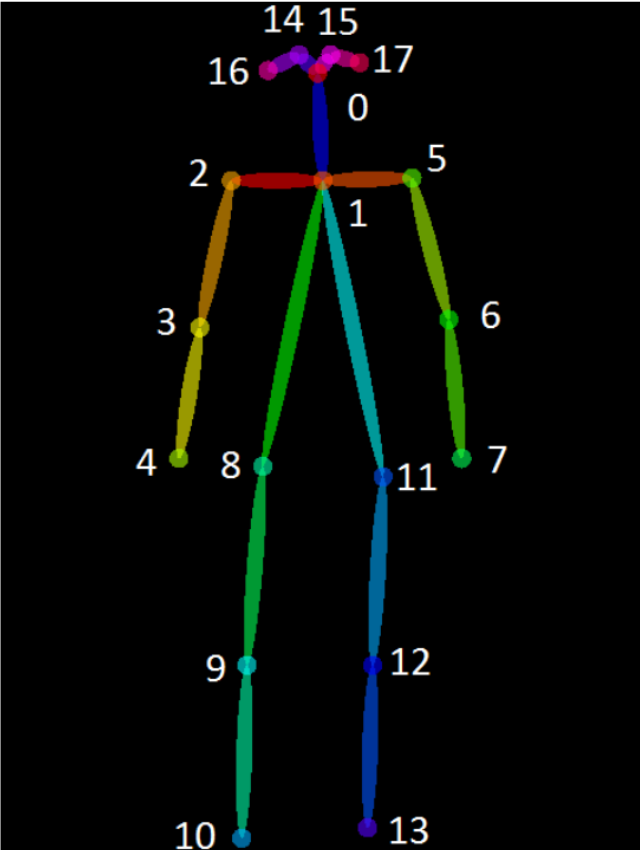

In [43]:
import sys
import numpy as np
import cv2
from PIL import Image

# 모델 및 설정 파일
model = '/Users/jungjihoon/Desktop/openpose/pose_iter_440000.caffemodel'
config = '/Users/jungjihoon/Desktop/openpose/pose_deploy_linevec.prototxt.txt'

# 포즈 점 개수, 점 연결 개수, 연결 점 번호 쌍
nparts = 18 # 전체 점의 개수
npairs = 17 # 점과 점 사이를 잇는 직선의 개수(관절 표현)

# 관전을 어떻게 이을건지 설명해준다.
pose_pairs = [(1, 2), (2, 3), (3, 4),  # 왼팔: 1번점 2번점, 2번점 3번점, 3번점 4번점을 연결하면 왼팔이된다
              (1, 5), (5, 6), (6, 7),  # 오른팔
              (1, 8), (8, 9), (9, 10),  # 왼쪽다리
              (1, 11), (11, 12), (12, 13),  # 오른쪽다리
              (1, 0), (0, 14), (14, 16), (0, 15), (15, 17)]  # 얼굴

# 테스트 이미지 파일
img_files = ["./pose1.jpeg", "./pose2.jpeg", "./pose3.jpeg"]
imgs = []
# 네트워크 설정
net = cv2.dnn.readNet(model, config)

for f in img_files:
    img = cv2.imread(f)
    
    blob = cv2.dnn.blobFromImage(img, 1/255., (368,368))
    net.setInput(blob)
    out = net.forward() # out.shape=(1, 57, 46, 46) 46*46가 57개, 앞에서 18개만 사용(keypoint)
    
    h, w = img.shape[:2]
    
    # 검출된 점 추출
    points = []
    for i in range(nparts): #nparts : 18
        
        # heatMap 46*46 짜리 행렬
        # heatMap 모양 : 관절부분 point 부분에서 heatmap생김
        heatMap = out[0,i,:,:] # 46*46의 float32 행렬
        
#         ##heatmap 시각화
#         heatImg = cv2.normalize(heatMap, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U) #0~1 -> 0~255
#         heatImg = cv2.resize(heatImg, (w, h))
#         heatImg = cv2.cvtColor(heatImg, cv2.COLOR_GRAY2BGR)
#         heatImg = cv2.addWeighted(img, 0.5, heatImg, 0.5, 0)
#         cv2.imshow('heatImg', heatImg)
#         cv2.waitKey()
        # point : 46*46 행렬에서의 최대값 위치
        _, conf, _, point = cv2.minMaxLoc(heatMap)
        
        # point 최대값 위치가 전체 영상에서는 어디에 위치해 있는가를 알기 위함 -> w, h곱셈
        # 입력영상 해상도에 맞는 특정 관정 위치 x,y => (21,9) 위치를 정 사이즈로 변환
        x = int(w * point[0] / out.shape[3]) # out.shape[3] : 46, point[0] : 21
        y = int(h * point[1] / out.shape[2]) # out.shape[2] : 46, point[1] : 9
        
        points.append((x,y) if conf > 0.1 else None) # heat map threshold : 0.1
    
    # 검출 결과 영상 만들기
    for pair in pose_pairs:
        
        p1 = points[pair[0]]
        p2 = points[pair[1]]
        
        if p1 is None or p2 is None: # 63번 줄에서 None이 들어오면 무시
            continue
            
        cv2.line(img, p1, p2, (0, 255, 0), 3, cv2.LINE_AA)
        
        # 각각의 끝점을 원으로 그리기
        cv2.circle(img, p1, 4, (0,0,255), -1, cv2.LINE_AA)
        cv2.circle(img, p2, 4, (0,0,255), -1, cv2.LINE_AA)
        
    # 추론 시간 출력
    t, _ = net.getPerfProfile()
    label = 'inference time : %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(img, label, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), cv2.LINE_4)
    
    imgs.append(img)
    

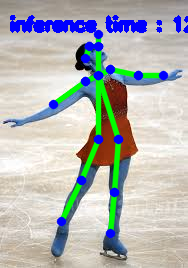

In [44]:
Image.fromarray(imgs[0])

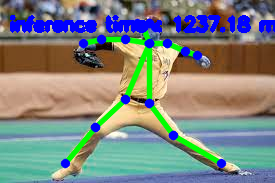

In [45]:
Image.fromarray(imgs[1])

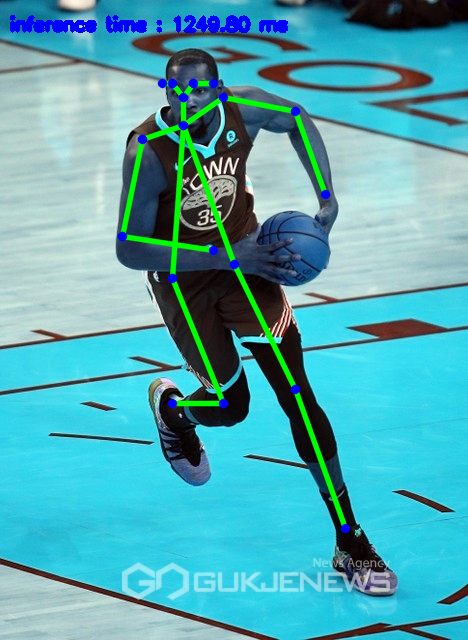

In [46]:
Image.fromarray(imgs[2])